<a href="https://colab.research.google.com/github/BoomLouke/ML-Final-Project-2026/blob/main/2_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Final Project 2026 - Model Experiments
In this file the different experiments for the data analysis wil be performed. First we will tackle classical machine learning. Throughout this file I will comment on what has been done in order to keep this document structured.

## 0. Loading in packages and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


import torch
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ML-Final-Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Running logistic regression pipeline

In [8]:
train_df = pd.read_csv('data/preprocessed_extensive/train.csv')
val_df = pd.read_csv('data/preprocessed_extensive/validation.csv')
test_df = pd.read_csv('data/preprocessed_extensive/test.csv')

print("Data loaded")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Data loaded
Train: 15956
Validation: 1988
Test: 1986


TF-IDF shape: (15956, 5000)
RESULTS - LOGISTIC REGRESSION
Train Accuracy: 0.9348207570819754
Validation Accuracy: 0.8767605633802817
Test Accuracy: 0.878147029204431
Validation F1-Score (macro): 0.8483079468287738
Test F1-Score (macro): 0.8415202291217393
CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

     sadness       0.94      0.88      0.91       579
         joy       0.93      0.88      0.90       688
        love       0.70      0.91      0.79       156
       anger       0.85      0.89      0.87       274
        fear       0.90      0.84      0.87       224
    surprise       0.60      0.86      0.71        65

    accuracy                           0.88      1986
   macro avg       0.82      0.88      0.84      1986
weighted avg       0.89      0.88      0.88      1986



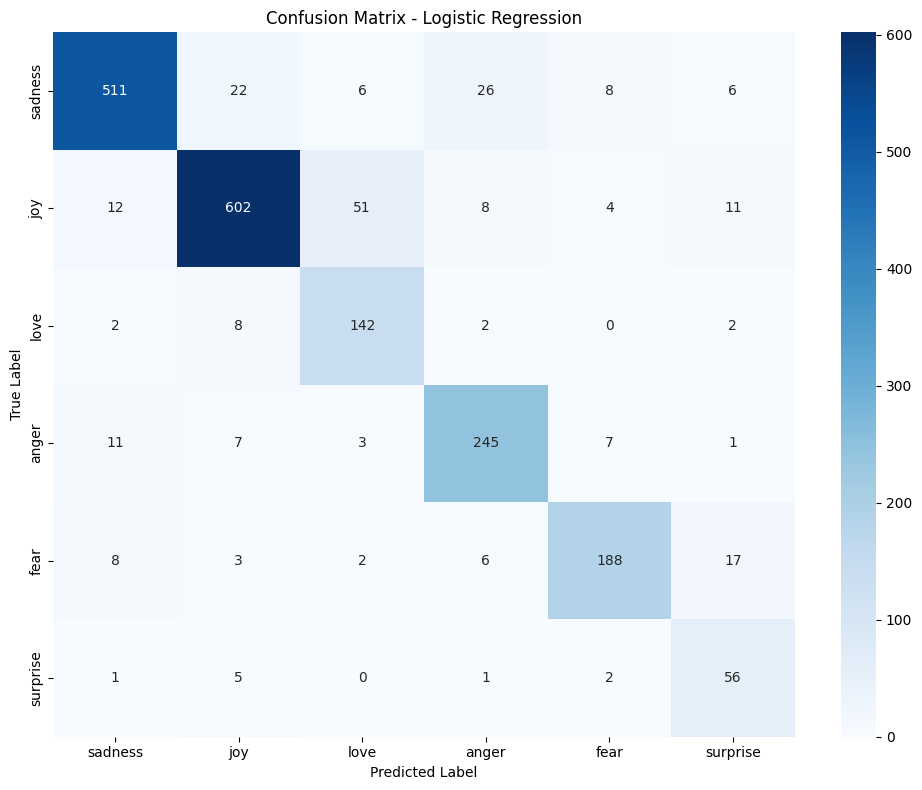

In [5]:
X_train = train_df['text']
y_train = train_df['label']

X_val = val_df['text']
y_val = val_df['label']

X_test = test_df['text']
y_test = test_df['label']

# Create TF-IDF features
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Terms that only appear in two documents are ignored
    max_df=0.95  # Terms that appear in 95´of the documents are ignored
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

# Train Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train_tfidf)
y_val_pred = lr_model.predict(X_val_tfidf)
y_test_pred = lr_model.predict(X_test_tfidf)

# Evaluation
print("RESULTS - LOGISTIC REGRESSION")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("Validation F1-Score (macro):", f1_score(y_val, y_val_pred, average='macro'))
print("Test F1-Score (macro):", f1_score(y_test, y_test_pred, average='macro'))

# Detailed classification report on test set
print("CLASSIFICATION REPORT (Test Set)")
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print(classification_report(y_test, y_test_pred, target_names=target_names))

# This code produces a confusion matrix to visualize the results
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_lr.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Running BERT (DistilBERT)

loading data

In [9]:
train_df = pd.read_csv('data/preprocessed_minimal/train.csv')
val_df = pd.read_csv('data/preprocessed_minimal/validation.csv')
test_df = pd.read_csv('data/preprocessed_minimal/test.csv')

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 15956
Validation: 1988
Test: 1986


training model

In [10]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
print(dataset_dict)

# Load tokenizer and model
model_name = "distilbert-base-uncased"
print(f"\nLoading tokenizer and model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6  # 6 emotions
).to(device)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128  # Most texts are short
    )

# Tokenize datasets
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Here we define the metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,
    seed=42
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15956
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1988
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1986
    })
})

Loading tokenizer and model: distilbert-base-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15956 [00:00<?, ? examples/s]

Map:   0%|          | 0/1988 [00:00<?, ? examples/s]

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

/tmp/ipython-input-974425495.py:69: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.235800,0.168730,0.941147,0.912872,0.940606
2,0.123300,0.145468,0.942153,0.919521,0.942596
3,0.093300,0.143180,0.947183,0.925430,0.947122


TrainOutput(global_step=2994, training_loss=0.23964574883281986, metrics={'train_runtime': 618.7076, 'train_samples_per_second': 77.368, 'train_steps_per_second': 4.839, 'total_flos': 1585350441547776.0, 'train_loss': 0.23964574883281986, 'epoch': 3.0})

evaluation on model

RESULTS - BERT (DistilBERT)

Test Accuracy: 0.9295
Test F1-Score (macro): 0.8875
Test F1-Score (weighted): 0.9300
CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       579
         joy       0.95      0.95      0.95       688
        love       0.83      0.88      0.85       156
       anger       0.94      0.93      0.93       274
        fear       0.93      0.84      0.88       224
    surprise       0.68      0.82      0.74        65

    accuracy                           0.93      1986
   macro avg       0.88      0.90      0.89      1986
weighted avg       0.93      0.93      0.93      1986



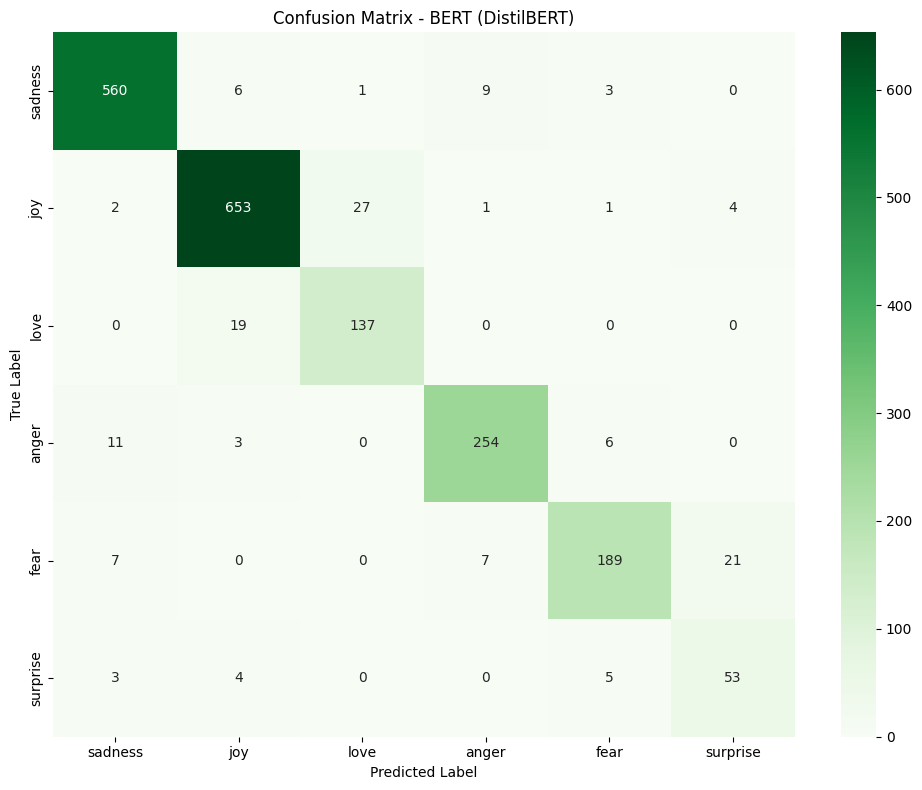

VALIDATION RESULTS
Validation Accuracy: 0.9472
Validation F1-Score (macro): 0.9254
Validation Loss: 0.1432


In [12]:
predictions = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_df['label'].values

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("RESULTS - BERT (DistilBERT)")
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (macro): {test_f1_macro:.4f}")
print(f"Test F1-Score (weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print("CLASSIFICATION REPORT (Test Set)")
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix - BERT (DistilBERT)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Get validation results from training
val_results = trainer.evaluate(tokenized_datasets['validation'])
print("VALIDATION RESULTS")
print(f"Validation Accuracy: {val_results['eval_accuracy']:.4f}")
print(f"Validation F1-Score (macro): {val_results['eval_f1_macro']:.4f}")
print(f"Validation Loss: {val_results['eval_loss']:.4f}")